In [1]:
import sys
# to import local fuctions
sys.path.insert(0, '../tools')
import pandas as pd

from datetime import timedelta
import numpy as np
from hurst import compute_Hc, random_walk
from matplotlib import pyplot as plt

from run_all import main
from extract.price_extract import main_prices
from extract.zacks_extract import zacks_extract
from indicators.indicators import main_indicators, run_indicators
from signals.track_record import signal_track_record

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

# Running Full Script

In [2]:
# If you want to run it on a small pool of stocks
#trades = main(stocks_path='../docs/my_stocks_test.csv')
# Run for all stocks
trades = main(skip_indicators=True, skip_price=True, skip_ratios=True)

1671 stocks will be analyzed

Start Update Prices Process ...
Using existing prices. No refresh.
It took 2 seconds to extract prices.

Calculate PE/PB Ratios and Market Cap
Skipping process. No refresh.
It took 0 seconds to update PE/PB Ratios and Market Caps.

Reading indicators file
It took 0.21666666666666667 minutes to generate indicators.

Create Buy/Sell Signals
It took 8 seconds to generate Buy and Sell Signals

The whole process took 0.4166666666666667 minutes. Happy Trading! =)


## See Trades generated

In [3]:
def show_me_trades(no_of_days, buy_signal, clean_data):
    
    # Define min date
    min_date = clean_data['timestamp'].max() - timedelta(days=no_of_days)
    
    relevant_columns = ['timestamp', 'symbol','name', 'industry', 'next_7d_return', 'next_14d_return', 'next_21d_return']

    # Create Metrics
    metrics = clean_data[(clean_data[buy_signal] == True)][relevant_columns]
    metrics['year'] = pd.DatetimeIndex(metrics['timestamp']).year
    metrics_a = metrics.groupby(['symbol', 'name', 'industry', 'year']).count()['timestamp'].reset_index()
    metrics_b = metrics.groupby(['symbol', 'name', 'industry', 'year']).mean()[['next_7d_return', 'next_14d_return', 'next_21d_return']].reset_index()
    metrics = pd.merge(metrics_a, metrics_b, on=['symbol', 'name', 'industry', 'year'])

    # Create set of good symbols
    list_of_good = set(metrics[(metrics['next_14d_return'] > 1) & (metrics['next_21d_return'] > 1) & (metrics['year'] >= 2019)]['symbol'])

    # Run for the past 5 days
    print('Only with past record')
    display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True) & (clean_data['symbol'].isin(list_of_good))][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return', 'close_price_x']])
    print('Everything')
    display(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True)][['timestamp', 'symbol', 'next_7d_return', 'next_14d_return', 'next_21d_return']])

    # Last days buys
    last_days_symbol = set(clean_data[(clean_data['timestamp'] > min_date) & (clean_data[buy_signal] == True) & (clean_data['symbol'].isin(list_of_good))]['symbol'])
    display(metrics[metrics['symbol'].isin(last_days_symbol)].sort_values('symbol'))

In [6]:
show_me_trades(2, 'buy_signal?1', trades)


Only with past record


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return,close_price_x
852547,2020-06-08 13:30:00,NEO,NaN,NaN,NaN,27.850000
852548,2020-06-09 14:52:41,NEO,NaN,NaN,NaN,27.775999
1040667,2020-06-09 14:55:16,DLR,NaN,NaN,NaN,141.619995
1291024,2020-06-09 14:55:31,HPQ,NaN,NaN,NaN,17.620001
1517939,2020-06-09 14:55:32,SPCE,NaN,NaN,NaN,16.830000


Everything


,timestamp,symbol,next_7d_return,next_14d_return,next_21d_return
852547,2020-06-08 13:30:00,NEO,NaN,NaN,NaN
852548,2020-06-09 14:52:41,NEO,NaN,NaN,NaN
1040667,2020-06-09 14:55:16,DLR,NaN,NaN,NaN
1291024,2020-06-09 14:55:31,HPQ,NaN,NaN,NaN
1517939,2020-06-09 14:55:32,SPCE,NaN,NaN,NaN


,symbol,name,industry,year,timestamp,next_7d_return,next_14d_return,next_21d_return
1545,DLR,"Digital Realty Trust, Inc.",Real Estate,2016,8,0.981647,0.979144,0.987761
1546,DLR,"Digital Realty Trust, Inc.",Real Estate,2017,6,0.988515,0.986313,0.970991
1547,DLR,"Digital Realty Trust, Inc.",Real Estate,2018,15,0.989432,0.984277,0.990779
1548,DLR,"Digital Realty Trust, Inc.",Real Estate,2019,10,1.001338,1.013125,1.039195
1549,DLR,"Digital Realty Trust, Inc.",Real Estate,2020,2,1.067526,1.041682,1.076164
2502,HPQ,HP Inc.,Technology,2017,3,1.026935,1.060090,1.105132
2503,HPQ,HP Inc.,Technology,2018,5,1.006086,0.985733,0.992933
2504,HPQ,HP Inc.,Technology,2019,9,0.979394,1.005468,1.001537
2505,HPQ,HP Inc.,Technology,2020,11,0.953246,0.965405,0.980844
3556,NEO,"NeoGenomics, Inc.",Healthcare,2016,7,0.982433,0.982540,0.968074


## Explore a Security Further

In [6]:
def create_charts_1(df, symbol, field='close_price_x', include_sell=True, what_to_print=[1,2,3,4,5]):
    # Filter using the symbol
    snap_df = df[df['symbol'] == symbol]
    
    # Plot Close Price
    snap_df[field].plot(figsize=(16,8), color='blue', alpha=0.3, label=field)
    
    # Buy and Sell Signals 
    if 1 in what_to_print:
        snap_df[snap_df['buy_signal?1'] == True][field].plot(linestyle='', marker='^', color='green', alpha = 0.5, markersize = 9, label='Buy Signal 1')
    if 2 in what_to_print:
        snap_df[snap_df['buy_signal?2'] == True][field].plot(linestyle='', marker='^', color='orange', alpha = 0.5, markersize = 9, label='Buy Signal 2')
    if 3 in what_to_print:
        snap_df[snap_df['buy_signal?3'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 3')
    if 4 in what_to_print:
        snap_df[snap_df['buy_signal?4'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 4')
    if 5 in what_to_print:
        snap_df[snap_df['buy_signal?5'] == True][field].plot(linestyle='', marker='^', color='blue', alpha = 0.5, markersize = 9, label='Buy Signal 5')
    
    if include_sell == True:
        snap_df[snap_df['sell_signal?1'] == True][field].plot(linestyle='', marker='o', color='red', alpha = 0.5, markersize = 7, label='Sell Signal')
    
    if field == 'close_price_x':
        snap_df['sma_100d'].plot(color='red', alpha = 0.5, markersize = 7, label='200d')
        snap_df['sma_50d'].plot(color='green', alpha = 0.5, markersize = 7, label='50d')
    elif field == 'macd_line':
        snap_df['macd_signal_line'].plot(color='green', alpha = 0.5, markersize = 7, label='signal_line')

    # Title
    plt.title((symbol + ' - Buy/Sell Signals using ' + field), fontsize=15)
    plt.legend()
    
    plt.show();
              

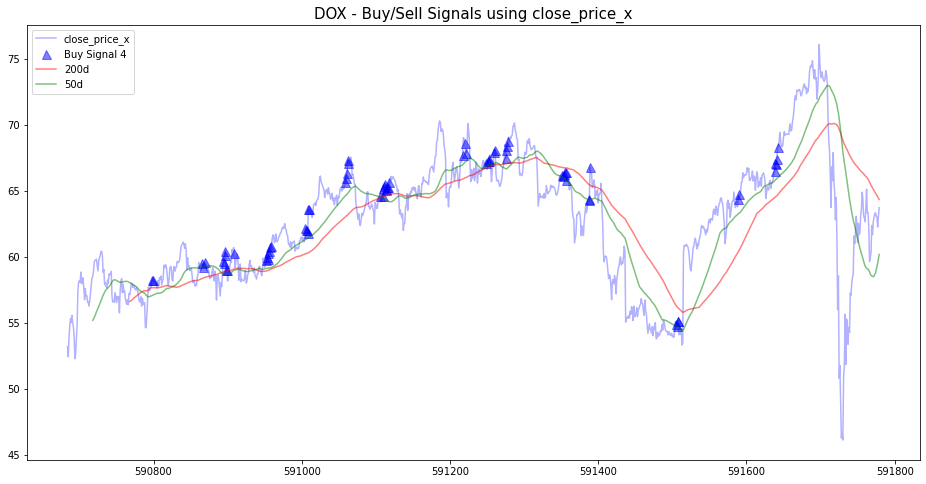

In [7]:
create_charts_1(trades, 'DOX', what_to_print=[4], include_sell=False)

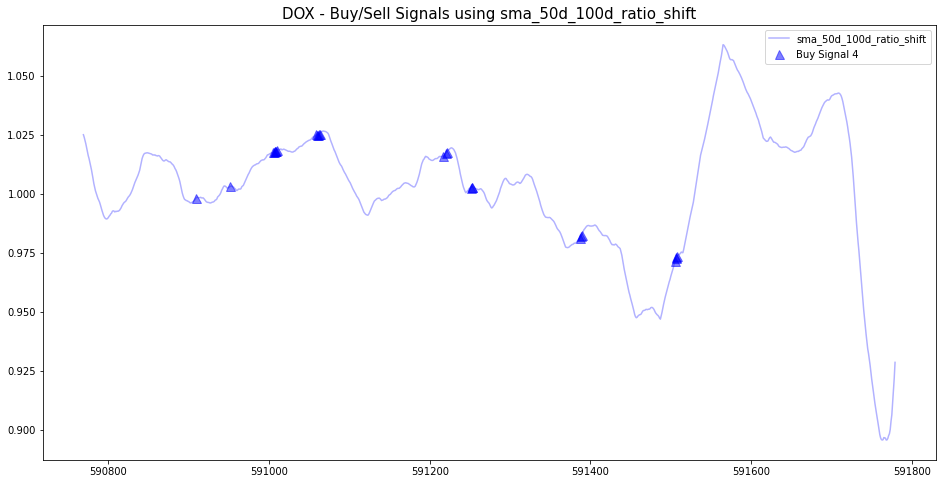

In [5]:
create_charts_1(trades, 'DOX', what_to_print=[4], include_sell=False, field='sma_50d_100d_ratio_shift')

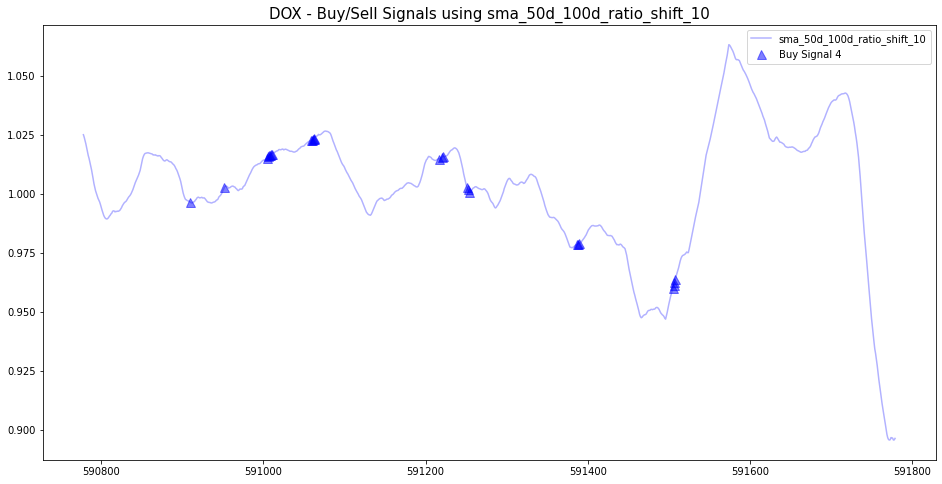

In [6]:
create_charts_1(trades, 'DOX', what_to_print=[4], include_sell=False, field='sma_50d_100d_ratio_shift_10')

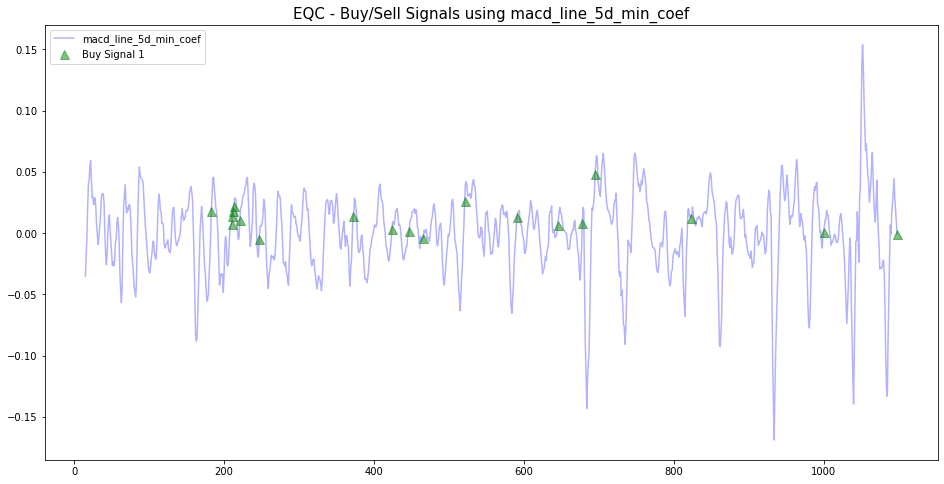

In [9]:
create_charts_1(trades, 'EQC', what_to_print=[1], include_sell=False, field='macd_line_5d_min_coef')

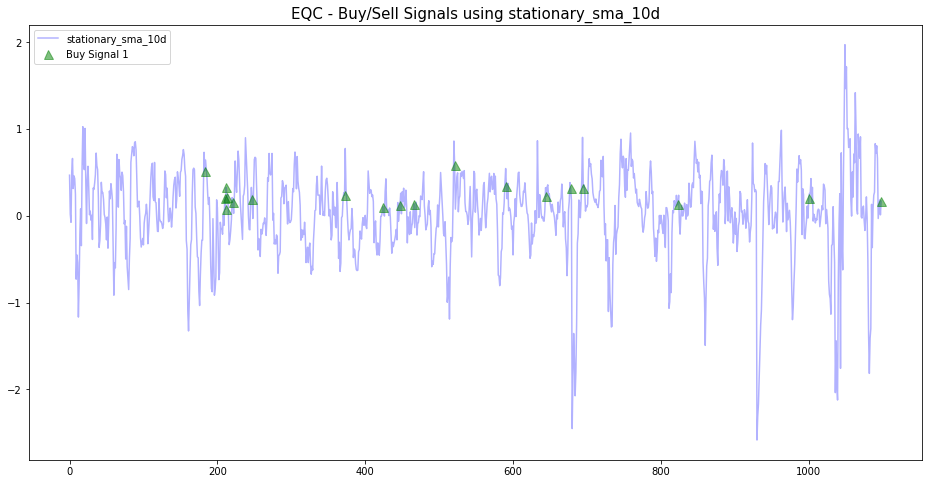

In [10]:
create_charts_1(trades, 'EQC', what_to_print=[1], include_sell=False, field='stationary_sma_10d')